<a href="https://colab.research.google.com/github/sboonpan/Project_Stock_LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")

%matplotlib inline 

In [4]:
symbol = 'PTT.BK'
start  = '2000-01-01'
end    = '2020-12-31'
stock = yf.download(symbol, start, end) 
stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-12-06,3.800,3.825,3.55,3.575,1.553146,1736808000
2001-12-07,3.625,3.625,3.55,3.550,1.542284,412533000
2001-12-10,3.550,3.550,3.55,3.550,1.542284,0
2001-12-11,3.550,3.550,3.40,3.400,1.477118,409158000
2001-12-12,3.425,3.525,3.40,3.500,1.520562,307291000
...,...,...,...,...,...,...
2020-12-24,40.750,41.500,40.75,41.250,39.227222,45405500
2020-12-25,41.250,42.250,41.25,42.000,39.940445,32414000
2020-12-28,42.250,42.750,41.00,41.000,38.989479,60698100


In [5]:
df = stock.copy()

In [6]:
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
#df.sort_values('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-12-06,3.800,3.825,3.55,3.575,1.553146,1736808000
2001-12-07,3.625,3.625,3.55,3.550,1.542284,412533000
2001-12-10,3.550,3.550,3.55,3.550,1.542284,412533000
2001-12-11,3.550,3.550,3.40,3.400,1.477118,409158000
2001-12-12,3.425,3.525,3.40,3.500,1.520562,307291000
...,...,...,...,...,...,...
2020-12-24,40.750,41.500,40.75,41.250,39.227222,45405500
2020-12-25,41.250,42.250,41.25,42.000,39.940445,32414000
2020-12-28,42.250,42.750,41.00,41.000,38.989479,60698100


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4729 entries, 2001-12-06 to 2020-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4729 non-null   float64
 1   High       4729 non-null   float64
 2   Low        4729 non-null   float64
 3   Close      4729 non-null   float64
 4   Adj Close  4729 non-null   float64
 5   Volume     4729 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 258.6 KB


In [8]:
test_split=round(len(df)*0.20)

In [9]:
test_split

946

In [10]:
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]

In [11]:
print(df_for_training.shape)
print(df_for_testing.shape)

(3783, 6)
(946, 6)


In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [13]:
df_for_testing_scaled=scaler.transform(df_for_testing)

In [14]:
df_for_training_scaled

array([[0.02211302, 0.02250608, 0.0170778 , 0.01642336, 0.00604819,
        1.        ],
       [0.01781327, 0.0176399 , 0.0170778 , 0.01581508, 0.00571607,
        0.23751994],
       [0.01597051, 0.01581508, 0.0170778 , 0.01581508, 0.00571607,
        0.23751994],
       ...,
       [0.93611797, 0.9318735 , 0.92409867, 0.8880779 , 0.93552971,
        0.07371174],
       [0.90663392, 0.8978102 , 0.92156857, 0.892944  , 0.940489  ,
        0.07624744],
       [0.89680597, 0.8880779 , 0.90385824, 0.8686131 , 0.91569257,
        0.07659981]])

In [15]:
df_for_training_scaled.shape

(3783, 6)

In [16]:
df_for_testing_scaled

array([[0.87960693, 0.89537715, 0.90385824, 0.89537715, 0.94296865,
        0.0615169 ],
       [0.90417696, 0.8978102 , 0.91650846, 0.8880779 , 0.93552971,
        0.03235694],
       [0.89926293, 0.90024335, 0.92662868, 0.892944  , 0.940489  ,
        0.03354246],
       ...,
       [0.9668305 , 0.96958637, 0.96457934, 0.9270073 , 1.15071902,
        0.03494337],
       [0.94226048, 0.96350365, 0.96457934, 0.96350365, 1.19433479,
        0.02362859],
       [0.99140053, 0.98175182, 0.9962049 , 0.96350365, 1.19433479,
        0.03874069]])

In [17]:
df_for_testing_scaled.shape

(946, 6)

In [18]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY) 

In [19]:
trainX,trainY=createXY(df_for_training_scaled,30)

In [20]:
trainX.shape

(3753, 30, 6)

In [21]:
testX,testY=createXY(df_for_testing_scaled,30)

In [22]:
trainX[0]

array([[0.02211302, 0.02250608, 0.0170778 , 0.01642336, 0.00604819,
        1.        ],
       [0.01781327, 0.0176399 , 0.0170778 , 0.01581508, 0.00571607,
        0.23751994],
       [0.01597051, 0.01581508, 0.0170778 , 0.01581508, 0.00571607,
        0.23751994],
       [0.01597051, 0.01581508, 0.01328273, 0.01216545, 0.0037235 ,
        0.23557671],
       [0.01289926, 0.01520681, 0.01328273, 0.01459854, 0.00505187,
        0.17692458],
       [0.01474201, 0.01520681, 0.01581278, 0.01459854, 0.00505187,
        0.2147355 ],
       [0.01474201, 0.01520681, 0.01454776, 0.01338199, 0.0043877 ,
        0.15555711],
       [0.01412776, 0.01399026, 0.01454776, 0.01338199, 0.0043877 ,
        0.0402358 ],
       [0.01351351, 0.01338199, 0.01454776, 0.01338199, 0.0043877 ,
        0.0402358 ],
       [0.01351351, 0.01399026, 0.01391524, 0.01277372, 0.00405559,
        0.04535096],
       [0.01289926, 0.01399026, 0.01391524, 0.01338199, 0.0043877 ,
        0.04059393],
       [0.01351351, 0

In [23]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (3753, 30, 6)
trainY Shape--  (3753,)


In [24]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (916, 30, 6)
testY Shape--  (916,)


In [25]:
print("trainX[0]-- \n",trainX[0])
print("\ntrainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.02211302 0.02250608 0.0170778  0.01642336 0.00604819 1.        ]
 [0.01781327 0.0176399  0.0170778  0.01581508 0.00571607 0.23751994]
 [0.01597051 0.01581508 0.0170778  0.01581508 0.00571607 0.23751994]
 [0.01597051 0.01581508 0.01328273 0.01216545 0.0037235  0.23557671]
 [0.01289926 0.01520681 0.01328273 0.01459854 0.00505187 0.17692458]
 [0.01474201 0.01520681 0.01581278 0.01459854 0.00505187 0.2147355 ]
 [0.01474201 0.01520681 0.01454776 0.01338199 0.0043877  0.15555711]
 [0.01412776 0.01399026 0.01454776 0.01338199 0.0043877  0.0402358 ]
 [0.01351351 0.01338199 0.01454776 0.01338199 0.0043877  0.0402358 ]
 [0.01351351 0.01399026 0.01391524 0.01277372 0.00405559 0.04535096]
 [0.01289926 0.01399026 0.01391524 0.01338199 0.0043877  0.04059393]
 [0.01351351 0.01399026 0.01391524 0.01277372 0.00405559 0.04927311]
 [0.01289926 0.01338199 0.01391524 0.01277372 0.00405559 0.03047071]
 [0.01289926 0.01338199 0.01391524 0.01277372 0.00405559 0.02567338]
 [0.01289926 0.01399

In [26]:
trainY[0]

0.014742012986068878

In [27]:
trainY.shape

(3753,)

In [28]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [29]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,6)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [30]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/8
118/118 [==============================] - 9s 17ms/step - loss: 0.0157 - val_loss: 0.0119
Epoch 2/8
118/118 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 3/8
118/118 [==============================] - 1s 10ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 4/8
118/118 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 5/8
118/118 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 6/8
118/118 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 7/8
118/118 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0062
Epoch 8/8
118/118 [==============================] - 1s 4ms/step - loss: 8.4361e-04
Epoch 1/8
118/118 [==============================] - 5s 17ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 2/8
118/118 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 3/8
118/118

In [31]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [32]:
my_model=grid_search.best_estimator_.model

In [33]:
my_model

In [34]:
prediction=my_model.predict(testX)

In [35]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.9084353 ]
 [0.90393794]
 [0.8990249 ]
 [0.8926692 ]
 [0.8875176 ]
 [0.8836712 ]
 [0.8806446 ]
 [0.87883973]
 [0.87923497]
 [0.8804838 ]
 [0.88261104]
 [0.8834784 ]
 [0.8833554 ]
 [0.8829986 ]
 [0.8825103 ]
 [0.88132024]
 [0.87979126]
 [0.877941  ]
 [0.8761052 ]
 [0.8742005 ]
 [0.8737076 ]
 [0.8731541 ]
 [0.87284505]
 [0.8732124 ]
 [0.8731545 ]
 [0.8726194 ]
 [0.87162644]
 [0.86873996]
 [0.867419  ]
 [0.86952883]
 [0.87189394]
 [0.8743966 ]
 [0.8768069 ]
 [0.8789974 ]
 [0.8807306 ]
 [0.8824981 ]
 [0.8839275 ]
 [0.8837846 ]
 [0.8836788 ]
 [0.88314307]
 [0.8825474 ]
 [0.8810102 ]
 [0.8793466 ]
 [0.8759054 ]
 [0.87184775]
 [0.8690911 ]
 [0.86548895]
 [0.86237043]
 [0.859846  ]
 [0.8588601 ]
 [0.859142  ]
 [0.8579891 ]
 [0.8559607 ]
 [0.8546161 ]
 [0.85491836]
 [0.8536092 ]
 [0.85184926]
 [0.8510694 ]
 [0.85086834]
 [0.85103   ]
 [0.85043293]
 [0.84879565]
 [0.84490424]
 [0.841684  ]
 [0.84021807]
 [0.8388113 ]
 [0.83568454]
 [0.83410305]
 [0.83391994]
 [0.83418393]
 [0.8357

In [36]:
prediction.shape

(916, 1)

In [37]:
prediction_copies_array = np.repeat(prediction,6, axis=-1)

In [38]:
prediction_copies_array.shape

(916, 6)

In [39]:
prediction_copies_array

array([[0.9084353 , 0.9084353 , 0.9084353 , 0.9084353 , 0.9084353 ,
        0.9084353 ],
       [0.90393794, 0.90393794, 0.90393794, 0.90393794, 0.90393794,
        0.90393794],
       [0.8990249 , 0.8990249 , 0.8990249 , 0.8990249 , 0.8990249 ,
        0.8990249 ],
       ...,
       [0.93045753, 0.93045753, 0.93045753, 0.93045753, 0.93045753,
        0.93045753],
       [0.93182015, 0.93182015, 0.93182015, 0.93182015, 0.93182015,
        0.93182015],
       [0.9358193 , 0.9358193 , 0.9358193 , 0.9358193 , 0.9358193 ,
        0.9358193 ]], dtype=float32)

In [40]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),6)))[:,0]

In [41]:
pred

array([39.873314, 39.690273, 39.49031 , 39.231636, 39.021965, 38.865417,
       38.742233, 38.668774, 38.68486 , 38.735687, 38.822266, 38.85757 ,
       38.852562, 38.83804 , 38.81817 , 38.769733, 38.7075  , 38.6322  ,
       38.55748 , 38.479958, 38.459896, 38.43737 , 38.424793, 38.439743,
       38.437386, 38.415607, 38.375195, 38.257713, 38.203953, 38.28982 ,
       38.38608 , 38.48794 , 38.58604 , 38.67519 , 38.745735, 38.81767 ,
       38.875847, 38.87003 , 38.865726, 38.84392 , 38.819675, 38.75711 ,
       38.689404, 38.549347, 38.3842  , 38.272007, 38.125397, 37.998474,
       37.89573 , 37.855602, 37.867077, 37.820152, 37.7376  , 37.682873,
       37.695175, 37.64189 , 37.570263, 37.53852 , 37.53034 , 37.53692 ,
       37.51262 , 37.44598 , 37.2876  , 37.156536, 37.096874, 37.039616,
       36.912357, 36.847992, 36.840538, 36.851284, 36.91505 , 36.977833,
       37.05149 , 37.165817, 37.304337, 37.411407, 37.46128 , 37.470047,
       37.563896, 37.774258, 37.98495 , 38.147396, 

In [43]:
original_copies_array = np.repeat(testY,6, axis=-1)

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),6)))[:,0]

In [44]:
pred

array([39.873314, 39.690273, 39.49031 , 39.231636, 39.021965, 38.865417,
       38.742233, 38.668774, 38.68486 , 38.735687, 38.822266, 38.85757 ,
       38.852562, 38.83804 , 38.81817 , 38.769733, 38.7075  , 38.6322  ,
       38.55748 , 38.479958, 38.459896, 38.43737 , 38.424793, 38.439743,
       38.437386, 38.415607, 38.375195, 38.257713, 38.203953, 38.28982 ,
       38.38608 , 38.48794 , 38.58604 , 38.67519 , 38.745735, 38.81767 ,
       38.875847, 38.87003 , 38.865726, 38.84392 , 38.819675, 38.75711 ,
       38.689404, 38.549347, 38.3842  , 38.272007, 38.125397, 37.998474,
       37.89573 , 37.855602, 37.867077, 37.820152, 37.7376  , 37.682873,
       37.695175, 37.64189 , 37.570263, 37.53852 , 37.53034 , 37.53692 ,
       37.51262 , 37.44598 , 37.2876  , 37.156536, 37.096874, 37.039616,
       36.912357, 36.847992, 36.840538, 36.851284, 36.91505 , 36.977833,
       37.05149 , 37.165817, 37.304337, 37.411407, 37.46128 , 37.470047,
       37.563896, 37.774258, 37.98495 , 38.147396, 

In [45]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [39.873314 39.690273 39.49031  39.231636 39.021965 38.865417 38.742233
 38.668774 38.68486  38.735687 38.822266 38.85757  38.852562 38.83804
 38.81817  38.769733 38.7075   38.6322   38.55748  38.479958 38.459896
 38.43737  38.424793 38.439743 38.437386 38.415607 38.375195 38.257713
 38.203953 38.28982  38.38608  38.48794  38.58604  38.67519  38.745735
 38.81767  38.875847 38.87003  38.865726 38.84392  38.819675 38.75711
 38.689404 38.549347 38.3842   38.272007 38.125397 37.998474 37.89573
 37.855602 37.867077 37.820152 37.7376   37.682873 37.695175 37.64189
 37.570263 37.53852  37.53034  37.53692  37.51262  37.44598  37.2876
 37.156536 37.096874 37.039616 36.912357 36.847992 36.840538 36.851284
 36.91505  36.977833 37.05149  37.165817 37.304337 37.411407 37.46128
 37.470047 37.563896 37.774258 37.98495  38.147396 38.226807 38.175877
 38.059544 37.939213 37.85754  37.81472  37.808357 37.814026 37.785706
 37.816776 37.852818 37.907745 38.01667  38.224194 38.41133  38.57993

In [46]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [39.873314 39.690273 39.49031  39.231636 39.021965 38.865417 38.742233
 38.668774 38.68486  38.735687 38.822266 38.85757  38.852562 38.83804
 38.81817  38.769733 38.7075   38.6322   38.55748  38.479958 38.459896
 38.43737  38.424793 38.439743 38.437386 38.415607 38.375195 38.257713
 38.203953 38.28982  38.38608  38.48794  38.58604  38.67519  38.745735
 38.81767  38.875847 38.87003  38.865726 38.84392  38.819675 38.75711
 38.689404 38.549347 38.3842   38.272007 38.125397 37.998474 37.89573
 37.855602 37.867077 37.820152 37.7376   37.682873 37.695175 37.64189
 37.570263 37.53852  37.53034  37.53692  37.51262  37.44598  37.2876
 37.156536 37.096874 37.039616 36.912357 36.847992 36.840538 36.851284
 36.91505  36.977833 37.05149  37.165817 37.304337 37.411407 37.46128
 37.470047 37.563896 37.774258 37.98495  38.147396 38.226807 38.175877
 38.059544 37.939213 37.85754  37.81472  37.808357 37.814026 37.785706
 37.816776 37.852818 37.907745 38.01667  38.224194 38.41133  38.57993

In [47]:
import matplotlib.pyplot as plt

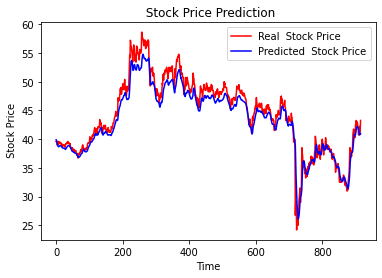

In [48]:
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()